# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 08.02.2024.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [4]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [5]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

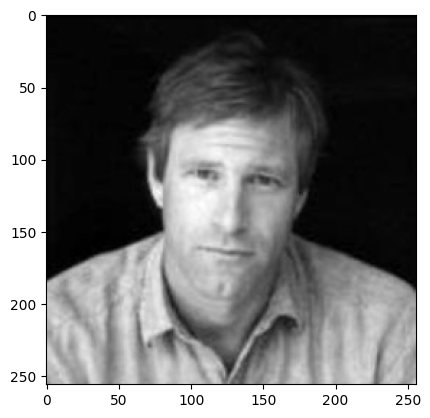

In [6]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [7]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [8]:
M = np.array([[]] * size)
nframes = 0
for im in images.keys():
    for pic in range(len(images[im])):
        a = images[im][pic]
        a.reshape((size ** 2, 1), order='F')
        M = np.hstack((M, a))
        nframes += 1

M = M.reshape((size ** 2, nframes), order='F')
M.shape

(65536, 1053)

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

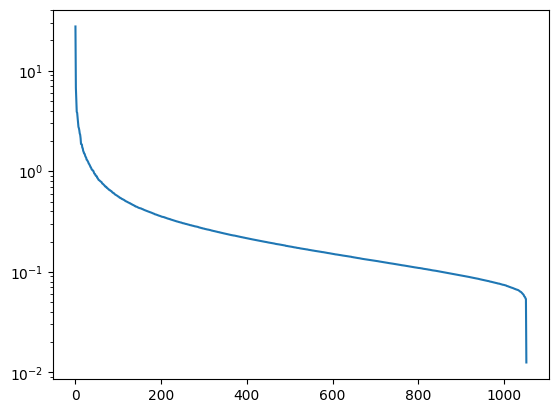

In [18]:
U, S, V = np.linalg.svd(M, full_matrices=False)

list(S).sort(reverse=True)
plt.semilogy(S)

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [19]:
M.shape

(65536, 1053)

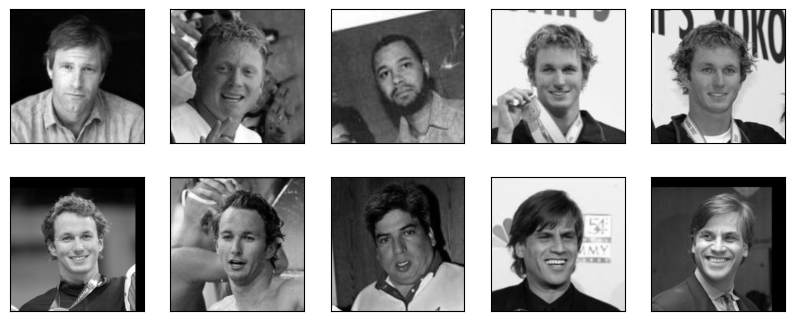

In [20]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''
    size = int(np.sqrt(mat.shape[0]))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes.reshape((rows, cols))[i,j].imshow(mat[:,i*cols + j].reshape((size, size), order='F'), cmap="gray")
            axes.reshape((rows, cols))[i,j].get_xaxis().set_visible(False)
            axes.reshape((rows, cols))[i,j].get_yaxis().set_visible(False)

plot_as_images(M, 2, 5)


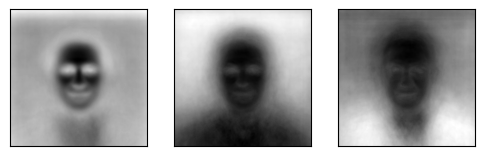

In [21]:
plot_as_images(U[:, 0:3], 1, 3)


Старшие 3 сингулярных вектора отвечают за контраст цвета, базовые черты лица, положение человека в пространстве

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [22]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation
            
        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''

    U, S, V = np.linalg.svd(M, full_matrices=False)
    C = np.diag(S[:r]) @ V[:r, :]
    error = np.sqrt(sum(S[r:] * S[r:])) / np.sqrt(sum(S * S))
    return U[:, 0:r], C, error


trunc_svd(M, 400)

(array([[-2.13203286e-03,  4.10396154e-03, -2.76098064e-04, ...,
          8.99105023e-03, -3.93480123e-03, -1.30290416e-03],
        [-2.17242604e-03,  4.11607931e-03, -2.58473025e-04, ...,
          1.15424751e-02, -3.55867362e-03,  2.47193291e-04],
        [-2.23040512e-03,  4.25365636e-03, -2.50169458e-04, ...,
          1.02926573e-02, -3.09449997e-03,  3.22065027e-03],
        ...,
        [-2.92573583e-03, -2.32342239e-03,  7.05628850e-03, ...,
         -4.91585424e-03, -6.42757320e-04, -2.66053311e-03],
        [-2.92339235e-03, -2.33912445e-03,  6.99454740e-03, ...,
         -5.39771267e-03, -3.86940000e-05, -1.50597774e-03],
        [-2.91796107e-03, -2.33081496e-03,  6.99719937e-03, ...,
         -6.59805224e-03, -4.95868845e-04, -1.97804899e-03]]),
 array([[-7.66120107e-01, -8.86135541e-01, -9.14898201e-01, ...,
         -8.92803199e-01, -8.60026080e-01, -9.02181214e-01],
        [-4.87151778e-01, -2.80315589e-02,  1.05467096e-01, ...,
          4.71715414e-02,  1.36659314e

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [25]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:,index].reshape((size, size), order='F'), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(appr.reshape((size, size), order='F'), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for j in range(count):
            axes[2 + j].imshow(U[:, j].reshape((size, size), order='F'), cmap="gray") # i-th singular vector image
            axes[2 + j].set_xlabel("{:.7}".format(C[j, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

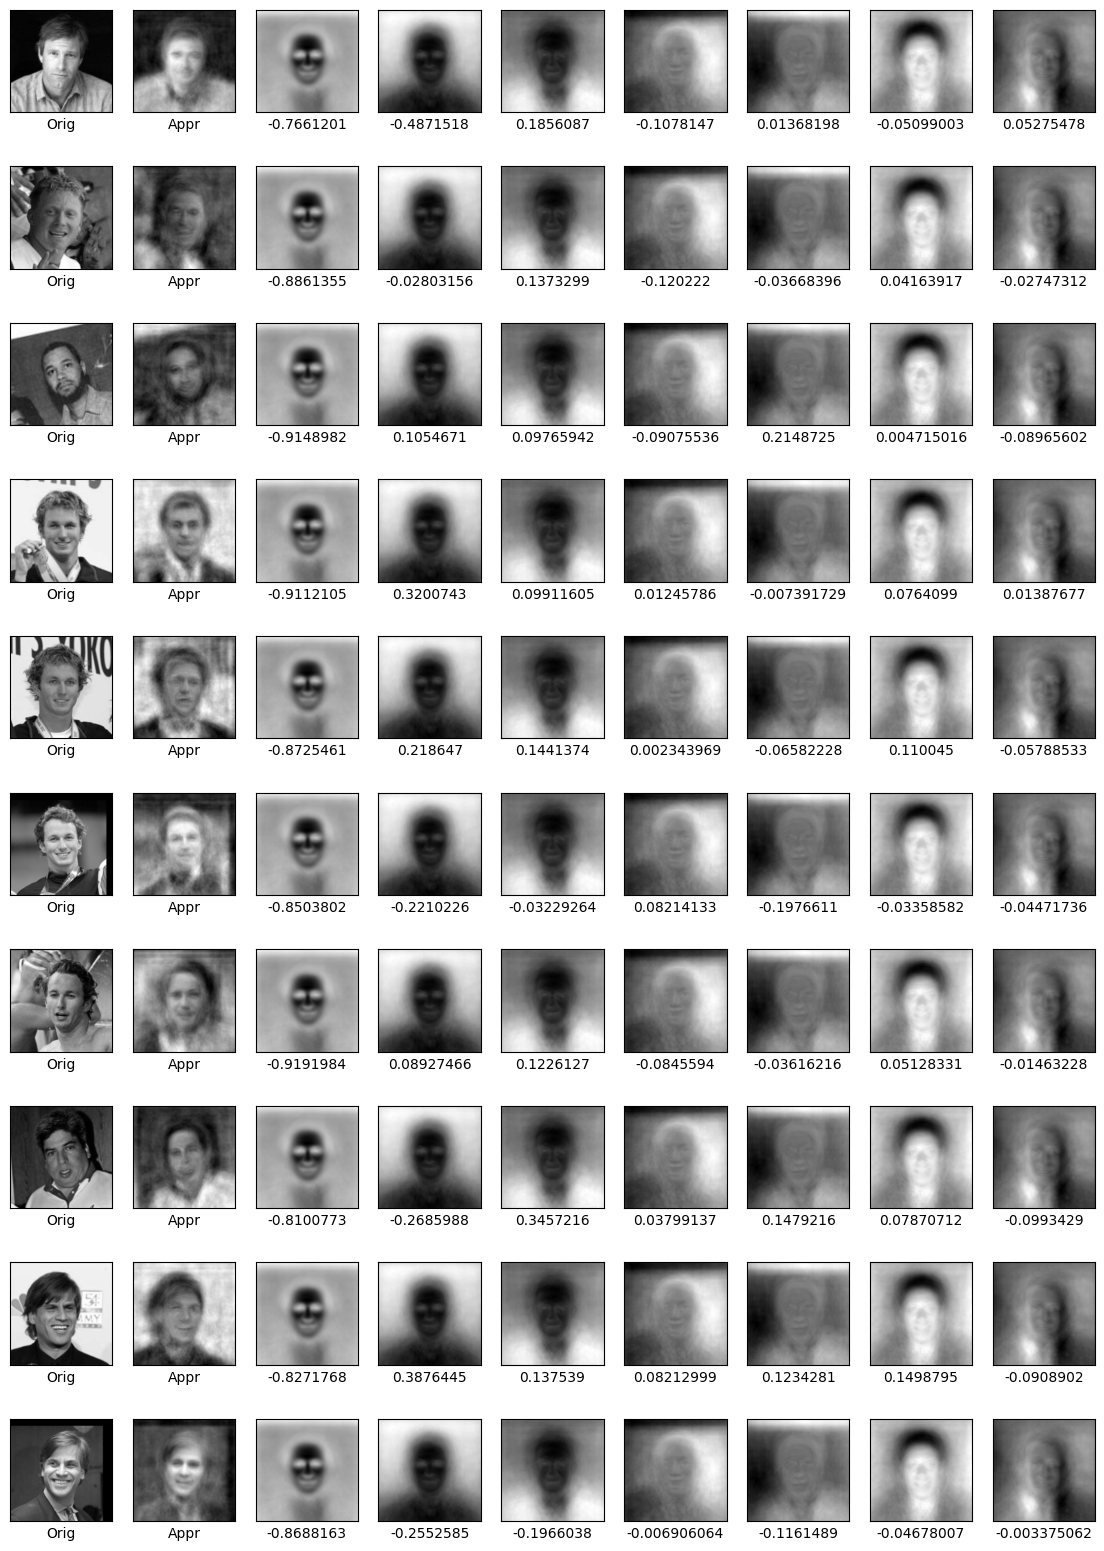

In [26]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [27]:
M.shape

(65536, 1053)

In [28]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy arrayi9
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''

    k = r + p
    n = M.shape[1]
    
    O = np.random.randn(n, k)
    Y = M @ O
    Q, R = np.linalg.qr(Y)

    U1, S, V = np.linalg.svd(Q.T.conj() @ M, full_matrices=False)
    U = Q @ U1

    Mr = U[:, :r] @ np.diag(S[:r]) @ V[:r, :]
    rel_eps = np.linalg.norm(M - Mr, ord='fro') / np.linalg.norm(M, ord='fro')
    return Mr, rel_eps


    

In [29]:
rand_svd(M, 10, p=10)

(array([[0.00019796, 0.0011792 , 0.00327618, ..., 0.00263786, 0.0028135 ,
         0.00345616],
        [0.00049326, 0.00138662, 0.00348613, ..., 0.00283745, 0.00313516,
         0.00388165],
        [0.00027153, 0.00134507, 0.00377929, ..., 0.00290279, 0.00332904,
         0.00419747],
        ...,
        [0.00234948, 0.0039037 , 0.00384785, ..., 0.00313111, 0.0025442 ,
         0.00232629],
        [0.00243099, 0.00385085, 0.00377887, ..., 0.00313321, 0.00249343,
         0.00226185],
        [0.00238189, 0.0038663 , 0.00374085, ..., 0.00315059, 0.00252203,
         0.00228675]]),
 0.44559191800112985)

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

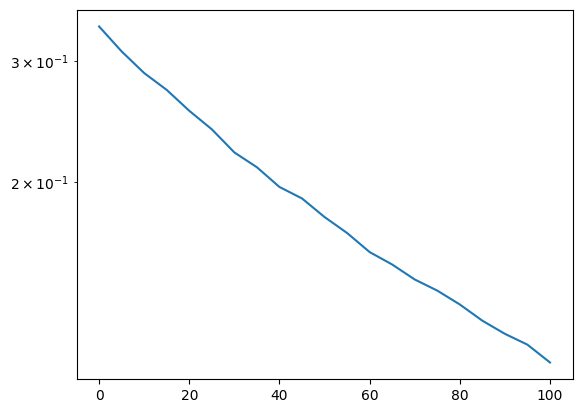

In [30]:
U, C, svd_err = trunc_svd(M, 50)

y = []
for p in range(0, 101, 5):
    r_err = 0
    for i in range(10):
        Mr, r_err_i = rand_svd(M, 50, p)
        r_err += r_err_i
    r_err /= 10
    y.append(r_err / svd_err - 1)

x = np.arange(0, 101, 5)
y = np.array(y)
plt.semilogy(x, y)

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [31]:
%timeit np.linalg.svd(M, full_matrices=False)

17.6 s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
trunc_svd(M, 50)

17 s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
rand_svd(M, 50, 0)

7.74 s ± 325 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Разница во времени работы примерно в 3 раза

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [34]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [35]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list of count indices of closest images
    """

    a = list(enumerate(np.linalg.norm(M - new_v[:, np.newaxis], ord=2, axis=0)))
    a.sort(key=lambda x: x[1])
    closest_images_ind = list(map(lambda x : x[0], a))[:count]
    
    
    return closest_images_ind
    

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

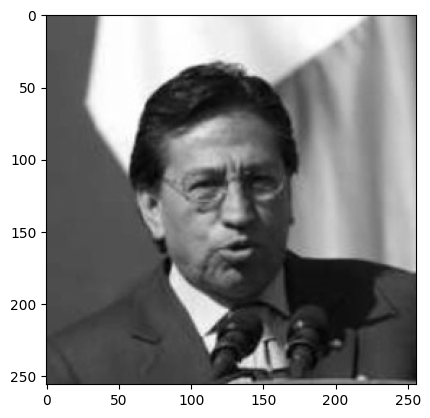

In [36]:
new = test_image
_ = plt.imshow(new, cmap="gray")

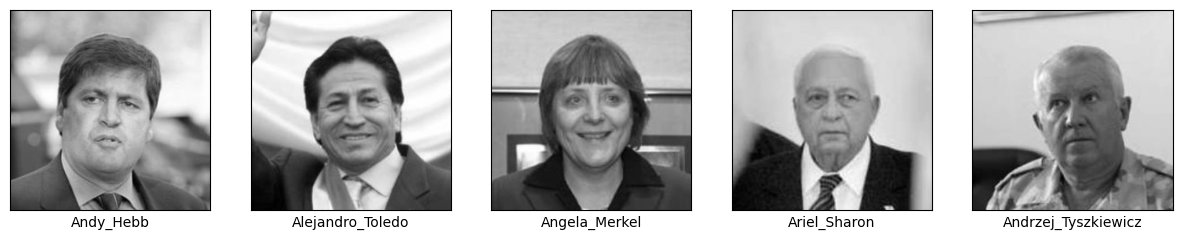

In [37]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [38]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list (of len `count`) of indices of closest images
    """

    U = U[:, 1:]
    C = C[1:, :]

    pr_images_U = U @ (np.linalg.inv(U.T @ U) @ (U.T @ (U @ C)))
    
    pr_new_v_U = U @ (np.linalg.inv(U.T @ U) @ (U.T @ new_v))

    a = list(enumerate(np.linalg.norm(pr_images_U - pr_new_v_U[:, np.newaxis], ord=2, axis=0)))
    a.sort(key=lambda x: x[1])
    closest_images_ind = list(map(lambda x : x[0], a))[:count]
    
    return closest_images_ind

    

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

In [39]:
U, C, svd_err = trunc_svd(M, 20)

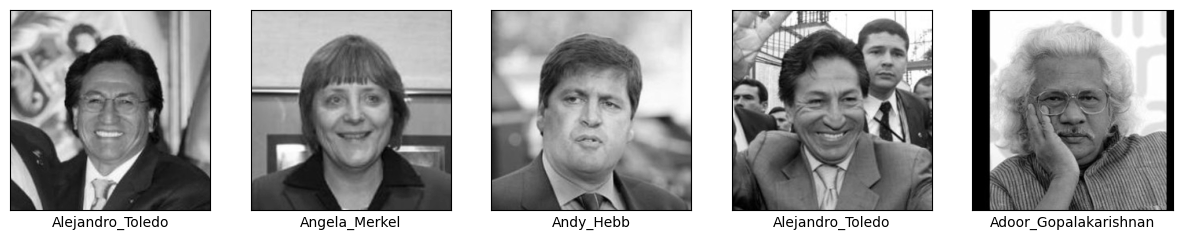

In [40]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

1. Распишем алгоритм 4.4 таким образом, что друг под другом будут располагаться равные элементы

![Эквивалентность алгоритмов](https://ibb.co/QNcsY9J)

Значит, оба алгоритма берут для приближения матрицу Q из QR-разложения одной и той же матрицы

2. Реализация 4.4

In [9]:
def randomized_subspace_iteration(A, l, q):
    n = A.shape[1]
    Sigma = np.random.randn(n, l)
    Y0 = A @ Sigma
    Q_prev, R_prev = np.linalg.qr(Y0)
    for i in range(q):
        Qt, Rt = np.linalg.qr(A.T @ Q_prev)
        Q_prev, R_prev = np.linalg.qr(A @ Qt)

    return Q_prev



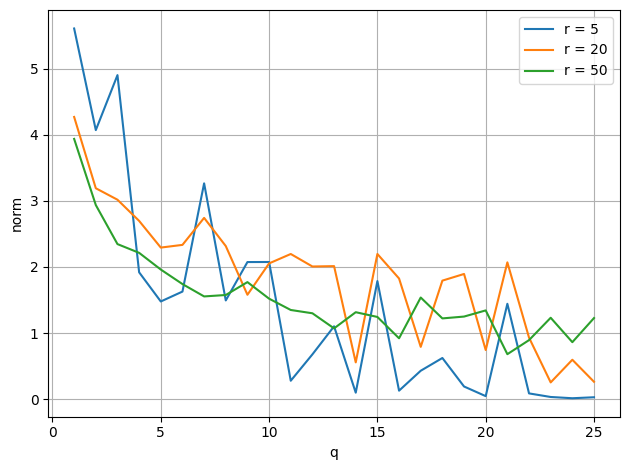

In [13]:
ranks = [5, 20, 50]
U_opt, Sigma_opt, V_opt = np.linalg.svd(M, full_matrices=False)

for r in ranks:
    cur_r_errors = []
    Mr_opt = U_opt[:, :r] @ np.diag(Sigma_opt[:r]) @ V_opt[:r, :]
    for q in range(1, 26):
        # l = r + 5
        Q_rsi = randomized_subspace_iteration(M, r, q)
        
        B = Q_rsi.T @ M
        U1, Sigma, V = np.linalg.svd(B, full_matrices=False)
        U = Q_rsi @ U1

        error = np.linalg.norm(U @ np.diag(Sigma) @ V - Mr_opt, ord='fro')
        cur_r_errors.append(error)
    
    
    plt.subplot()
    plt.plot(list(range(1, 26)), cur_r_errors, label=f'r = {r}')


plt.xlabel('q')
plt.ylabel('norm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()